In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime



In [22]:
msft = yf.Ticker("AAPL")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


msft.info

df = msft.history(period="5y")
df

df = df[['Close']]
df


yfinance.Ticker object <AAPL>


,Close
Date,
2019-07-12 00:00:00-04:00,49.051064
2019-07-15 00:00:00-04:00,49.511906
2019-07-16 00:00:00-04:00,49.340591
2019-07-17 00:00:00-04:00,49.063129
2019-07-18 00:00:00-04:00,49.620472
...,...
2024-07-08 00:00:00-04:00,227.820007
2024-07-09 00:00:00-04:00,228.679993
2024-07-10 00:00:00-04:00,232.979996


In [23]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

shifted_df_np = shifted_df.to_numpy()
shifted_df_np


array([[ 50.3877182 ,  49.99686432,  48.87975693, ...,  49.34059143,
         49.51190567,  49.05106354],
       [ 50.34670639,  50.3877182 ,  49.99686432, ...,  49.06312943,
         49.34059143,  49.51190567],
       [ 49.94861221,  50.34670639,  50.3877182 , ...,  49.62047195,
         49.06312943,  49.34059143],
       ...,
       [232.97999573, 228.67999268, 227.82000732, ..., 220.27000427,
        216.75      , 210.61999512],
       [227.57000732, 232.97999573, 228.67999268, ..., 221.55000305,
        220.27000427, 216.75      ],
       [231.99000549, 227.57000732, 232.97999573, ..., 226.33999634,
        221.55000305, 220.27000427]])

In [24]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape



[[-0.96405465 -0.97604516 -0.96734099 ... -0.97003081 -0.96725108
  -0.97231821]
 [-0.95985941 -0.96405465 -0.97547929 ... -0.97311901 -0.96921006
  -0.96700965]
 [-0.96029961 -0.95985941 -0.96320554 ... -0.9669157  -0.97238283
  -0.96898306]
 ...
 [ 0.95384579  0.94461512  0.97429028 ...  0.93244005  0.94511209
   0.88883888]
 [ 1.          0.95384579  0.99055127 ...  0.94668663  0.98536325
   0.9594521 ]
 [ 0.94193174  1.          1.         ...  1.          1.
   1.        ]]


(torch.Size([1189, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1189, 1]),
 torch.Size([63, 1]))

In [25]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [26]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 16, 2)
model.to(device)
model



torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [27]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


learning_rate = 0.003
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


Epoch: 1



Val Loss: 0.032
***************************************************

Epoch: 2

Val Loss: 0.022
***************************************************

Epoch: 3

Val Loss: 0.013
***************************************************

Epoch: 4

Val Loss: 0.015
***************************************************

Epoch: 5

Val Loss: 0.007
***************************************************

Epoch: 6

Val Loss: 0.011
***************************************************

Epoch: 7

Val Loss: 0.008
***************************************************

Epoch: 8

Val Loss: 0.004
***************************************************

Epoch: 9

Val Loss: 0.004
***************************************************

Epoch: 10

Val Loss: 0.003
***************************************************

Epoch: 11

Val Loss: 0.003
***************************************************

Epoch: 12

Val Loss: 0.008
***************************************************

Epoch: 13

Val Loss: 0.002
*******************************

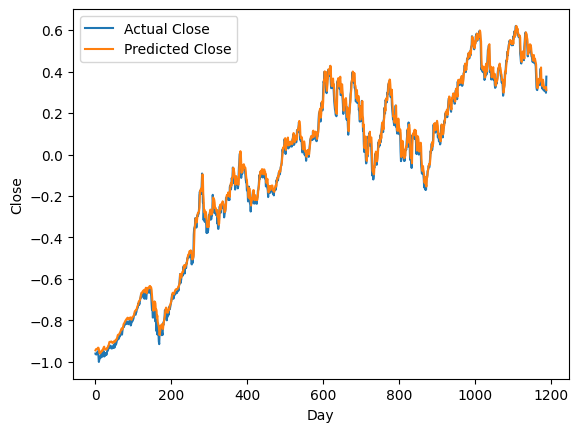

torch.Size([1189, 1])
(1189, 1)
(1189,)


In [28]:
plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)


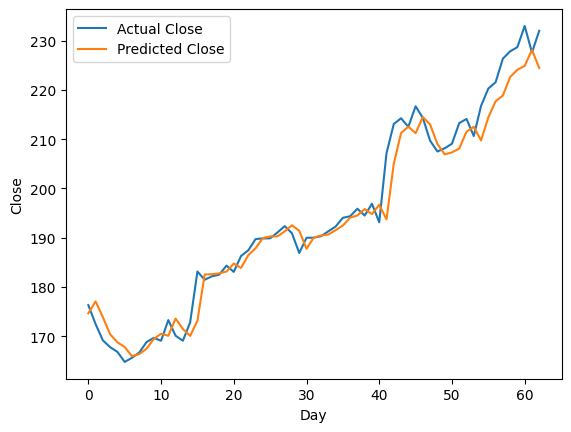

array([174.64761383, 177.06674468, 173.85685968, 170.38047457,
       168.76352621, 167.79842609, 165.93725955, 166.37314946,
       167.44735742, 169.43571   , 170.49677371, 170.08884657,
       173.57165109, 171.47333826, 170.06658686, 173.13709392,
       182.53129079, 182.57406097, 182.75898842, 183.12435918,
       184.74753537, 183.85878241, 186.46083048, 187.85703094,
       189.91152682, 190.25358277, 190.2618014 , 191.27055465,
       192.52116878, 191.39784897, 187.73987107, 190.02387213,
       190.42885611, 190.63665412, 191.52102843, 192.45455347,
       194.06491583, 194.51060978, 195.81592777, 194.78430119,
       196.68224887, 193.71775655, 205.00922916, 211.22740955,
       212.52011083, 211.21199407, 214.48737264, 212.95954086,
       209.01044584, 206.91341301, 207.30710749, 208.09221411,
       211.50280021, 212.50179662, 209.73677261, 214.41834728,
       217.67102467, 218.86463596, 222.61071422, 224.0954704 ,
       224.86170749, 228.11064763, 224.44030291])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train


test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


test_predictions



Test Results:
                        Date      Actual   Predicted
0  2024-04-12 00:00:00-04:00  176.310867  174.647614
1  2024-04-15 00:00:00-04:00  172.456086  177.066745
2  2024-04-16 00:00:00-04:00  169.150574  173.856860
3  2024-04-17 00:00:00-04:00  167.772446  170.380475
4  2024-04-18 00:00:00-04:00  166.813737  168.763526
..                       ...         ...         ...
58 2024-07-08 00:00:00-04:00  227.820008  222.610714
59 2024-07-09 00:00:00-04:00  228.679993  224.095470
60 2024-07-10 00:00:00-04:00  232.979996  224.861707
61 2024-07-11 00:00:00-04:00  227.570006  228.110648
62 2024-07-12 00:00:00-04:00  231.990006  224.440303

[63 rows x 3 columns]
                        Date      Actual   Predicted   Signal
0  2024-04-12 00:00:00-04:00  176.310867  174.647614  Neutral
1  2024-04-15 00:00:00-04:00  172.456086  177.066745      Buy
2  2024-04-16 00:00:00-04:00  169.150574  173.856860      Buy
3  2024-04-17 00:00:00-04:00  167.772446  170.380475      Buy
4  2024-04-18 00:

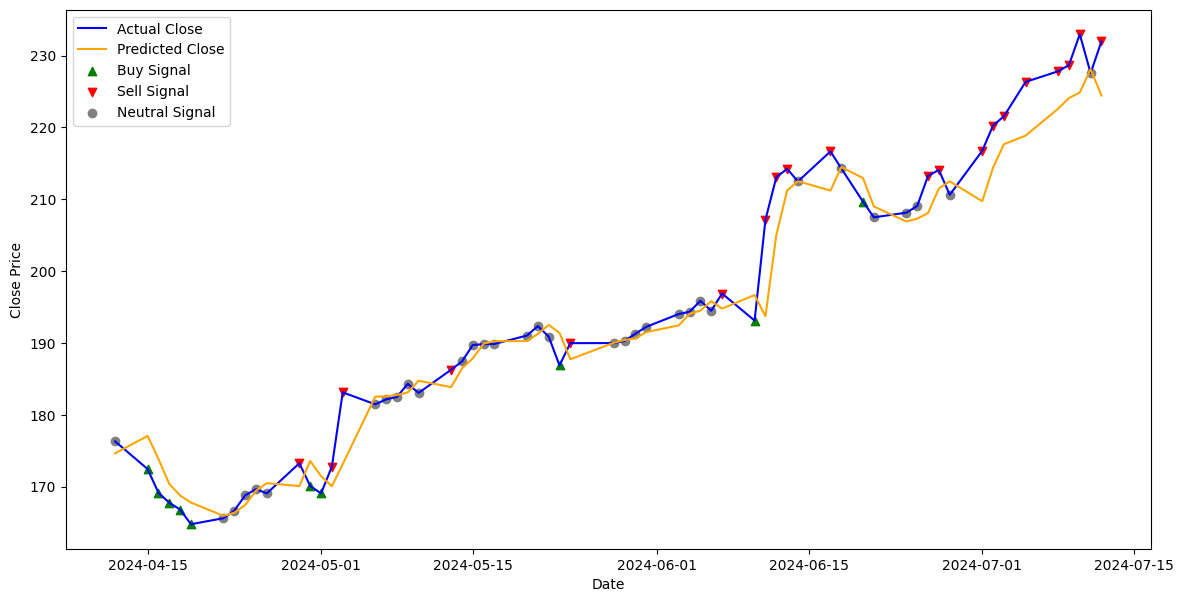

In [30]:
test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)


def generate_trading_signals(test_results_df, neutral_threshold=0.01):
    test_results_df['Signal'] = 'Neutral'

    test_results_df.loc[test_results_df['Predicted'] >
                        test_results_df['Actual'] * (1 + neutral_threshold), 'Signal'] = 'Buy'
    test_results_df.loc[test_results_df['Predicted'] <
                        test_results_df['Actual'] * (1 - neutral_threshold), 'Signal'] = 'Sell'

    return test_results_df


test_results_df_with_signals = generate_trading_signals(test_results_df)
print(test_results_df_with_signals)

# Visualization of trading signals
plt.figure(figsize=(14, 7))
plt.plot(test_results_df['Date'], test_results_df['Actual'],
         label='Actual Close', color='b')
plt.plot(test_results_df['Date'], test_results_df['Predicted'],
         label='Predicted Close', color='orange')
buy_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Buy']
sell_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Sell']
neutral_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Neutral']
plt.scatter(buy_signals['Date'], buy_signals['Actual'],
            label='Buy Signal', marker='^', color='g')
plt.scatter(sell_signals['Date'], sell_signals['Actual'],
            label='Sell Signal', marker='v', color='r')
plt.scatter(neutral_signals['Date'], neutral_signals['Actual'],
            label='Neutral Signal', marker='o', color='gray')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
